# KLIFS pocket

In [1]:
import numpy as np
import pandas as pd
import copy

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from missense_kinase_toolkit.databases import klifs, colors
from missense_kinase_toolkit.databases.kinase_schema import KLIFSPocket

In [2]:
# generate these in databases.ipynb
df_klifs = pd.read_csv("kinhub_klifs.csv")
df_uniprot = pd.read_csv("kinhub_uniprot.csv")

## Assess AA conservation of KLIFS pocket

In [3]:
# df_klifs["group"].value_counts()
# df_klifs.loc[~(df_klifs["pocket"].apply(lambda x: "-" in str(x))), "group"].value_counts()
# df_klifs.loc[~((df_klifs["pocket"].apply(lambda x: "-" in str(x))) | 
#               df_klifs["pocket"].apply(lambda x: len(str(x)) != 85)), "group"].value_counts()
# df_klifs.loc[(df_klifs["pocket"].apply(lambda x: "-" in str(x))), "gene_name"].to_list()

list_pocket = df_klifs.loc[~(df_klifs["pocket"].apply(lambda x: len(str(x)) != 85)), "pocket"].to_list()
list_name = df_klifs.loc[~(df_klifs["pocket"].apply(lambda x: len(str(x)) != 85)), "gene_name"].to_list()

dict_pocket = {name : {idx + 1 : aa for idx, aa in enumerate(pocket)} for name, pocket in zip(list_name, list_pocket)}
df_pocket = pd.DataFrame(dict_pocket).T

In [4]:
df_pocket_melt = pd.melt(df_pocket.reset_index(), id_vars='index')
df_pocket_melt.columns = ["gene_name", "position", "amino_acid"]

In [5]:
df_pocket_pivot = df_pocket_melt.pivot_table(index="amino_acid", columns="position", values="amino_acid", aggfunc="count")
# otherwise numeric
# df_pocket_pivot.columns = [str(col) for col in df_pocket_pivot.columns]
# df_pocket_pivot.loc[df_pocket_pivot.index == "K", 17]

In [6]:
df_pocket_count = pd.DataFrame(df_pocket_melt[["position", "amino_acid"]].value_counts())
df_pocket_count = df_pocket_count.reset_index()

ALPHABET_PROJECT
Invalid single-letter amino acid: -
- is an invalid amino acid; using '-' as default symbol.
ASAP
Invalid single-letter amino acid: -
- is an invalid amino acid; using '-' as default symbol.
RASMOL
Invalid single-letter amino acid: -
- is an invalid amino acid; using '-' as default symbol.
SHAPELY
Invalid single-letter amino acid: -
- is an invalid amino acid; using '-' as default symbol.
CLUSTALX
Invalid single-letter amino acid: -
- is an invalid amino acid; using '-' as default symbol.
ZAPPO
Invalid single-letter amino acid: -
- is an invalid amino acid; using '-' as default symbol.


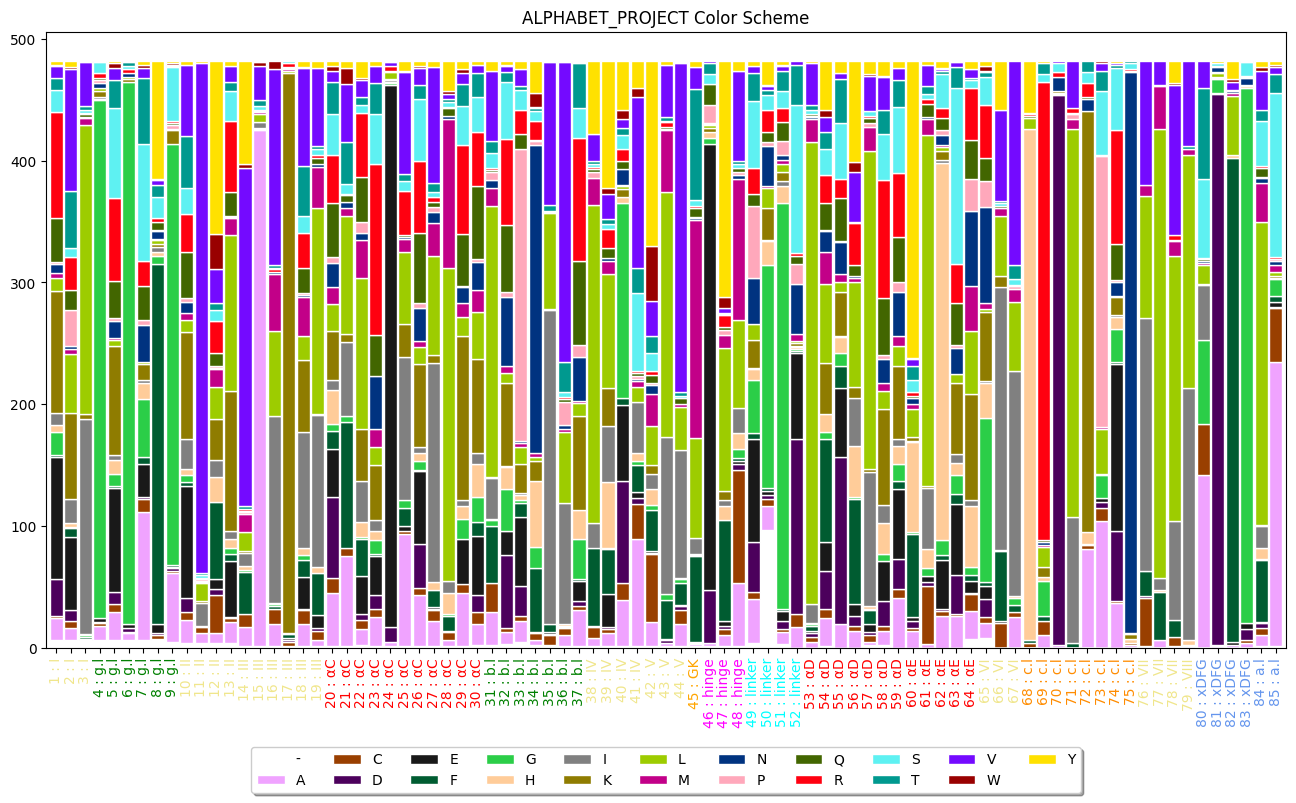

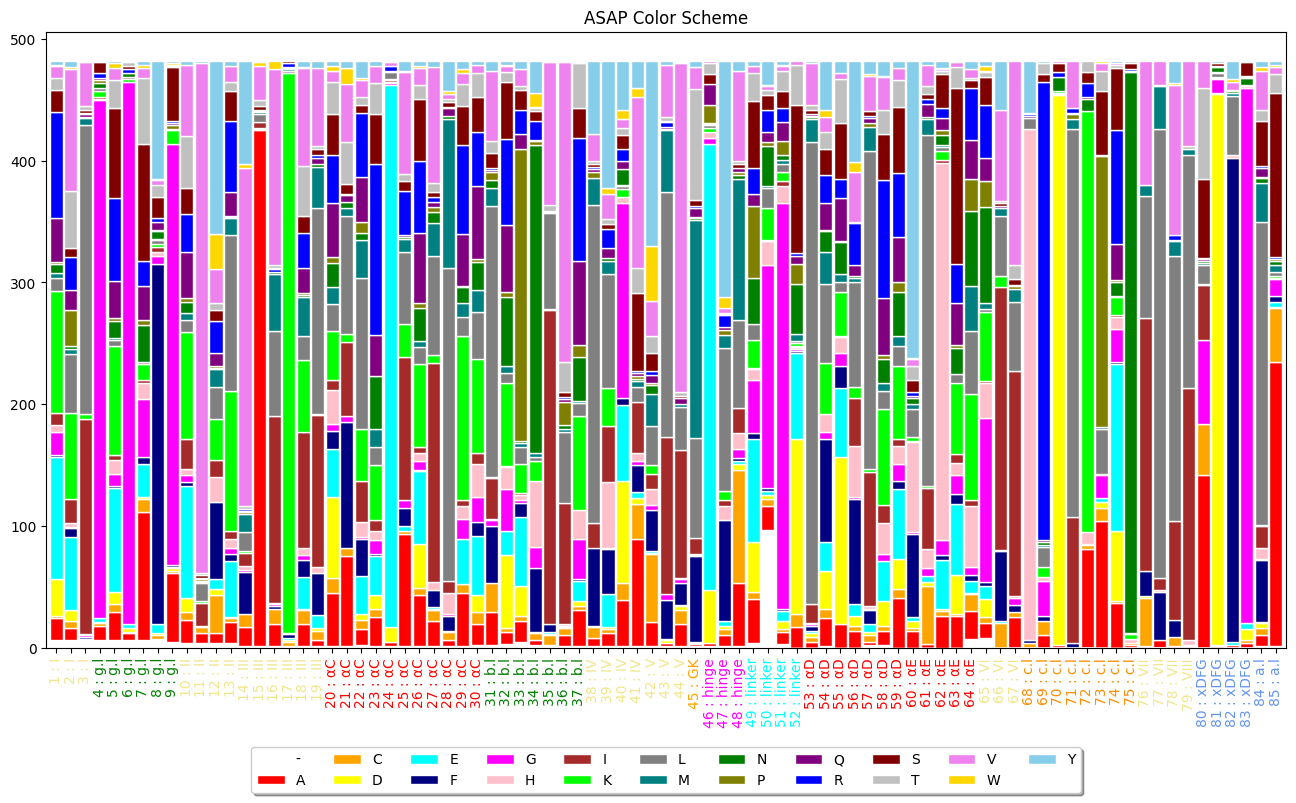

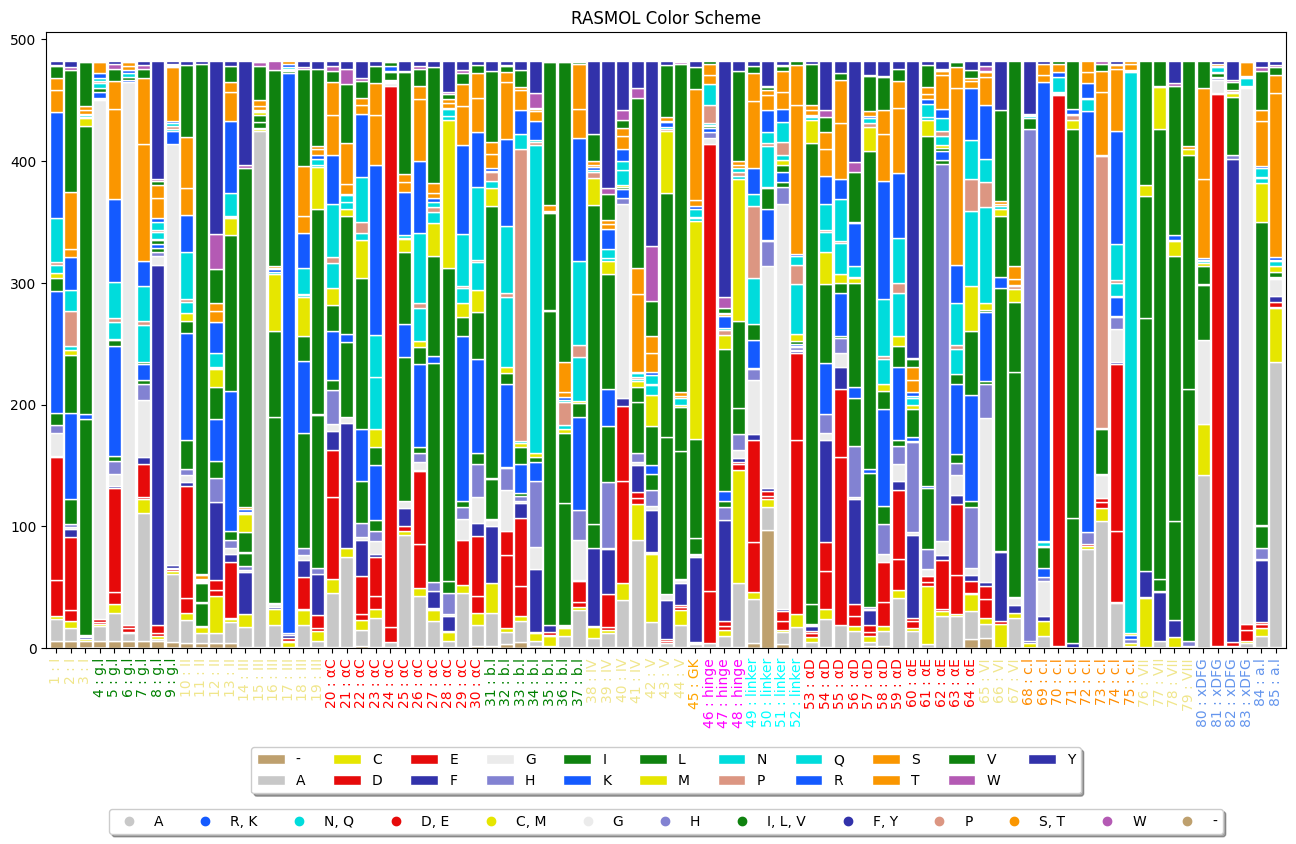

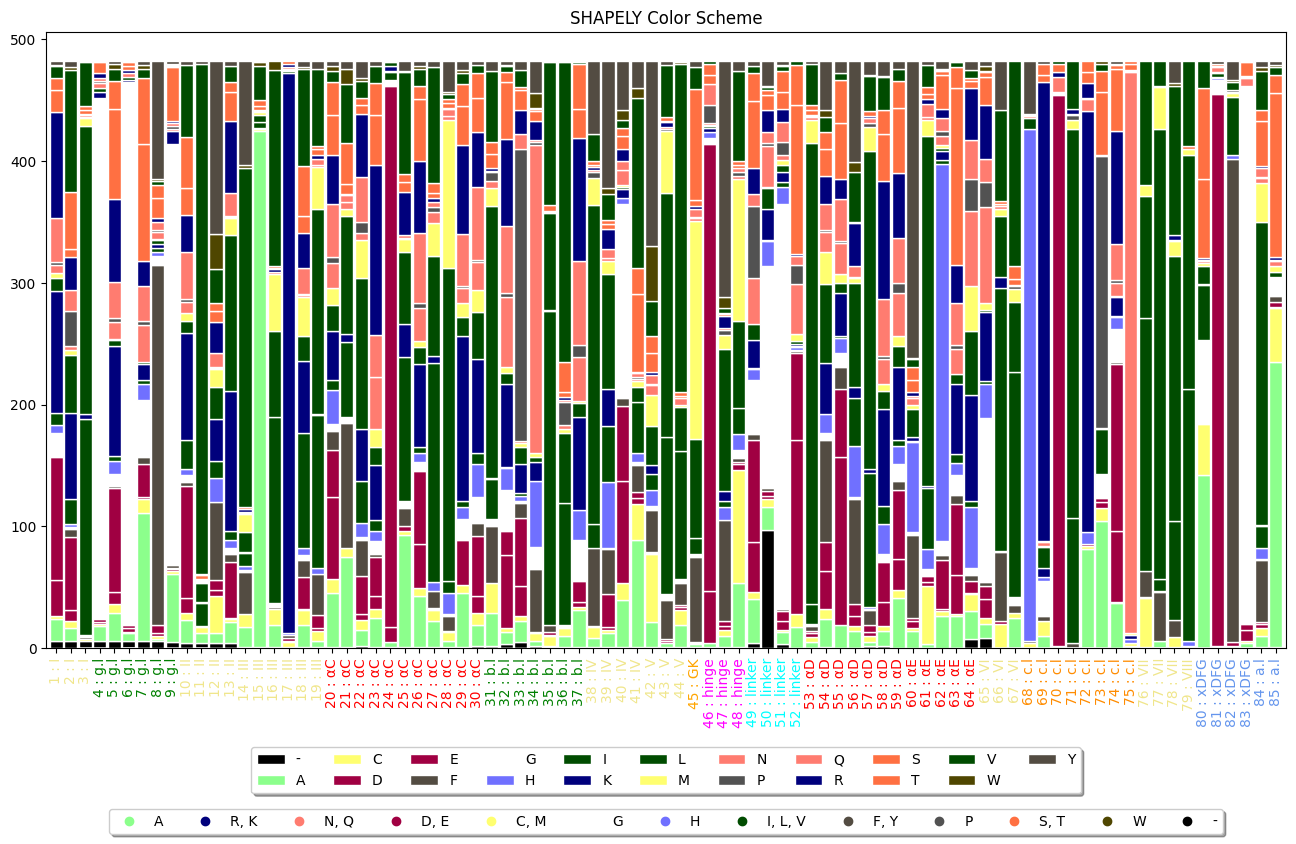

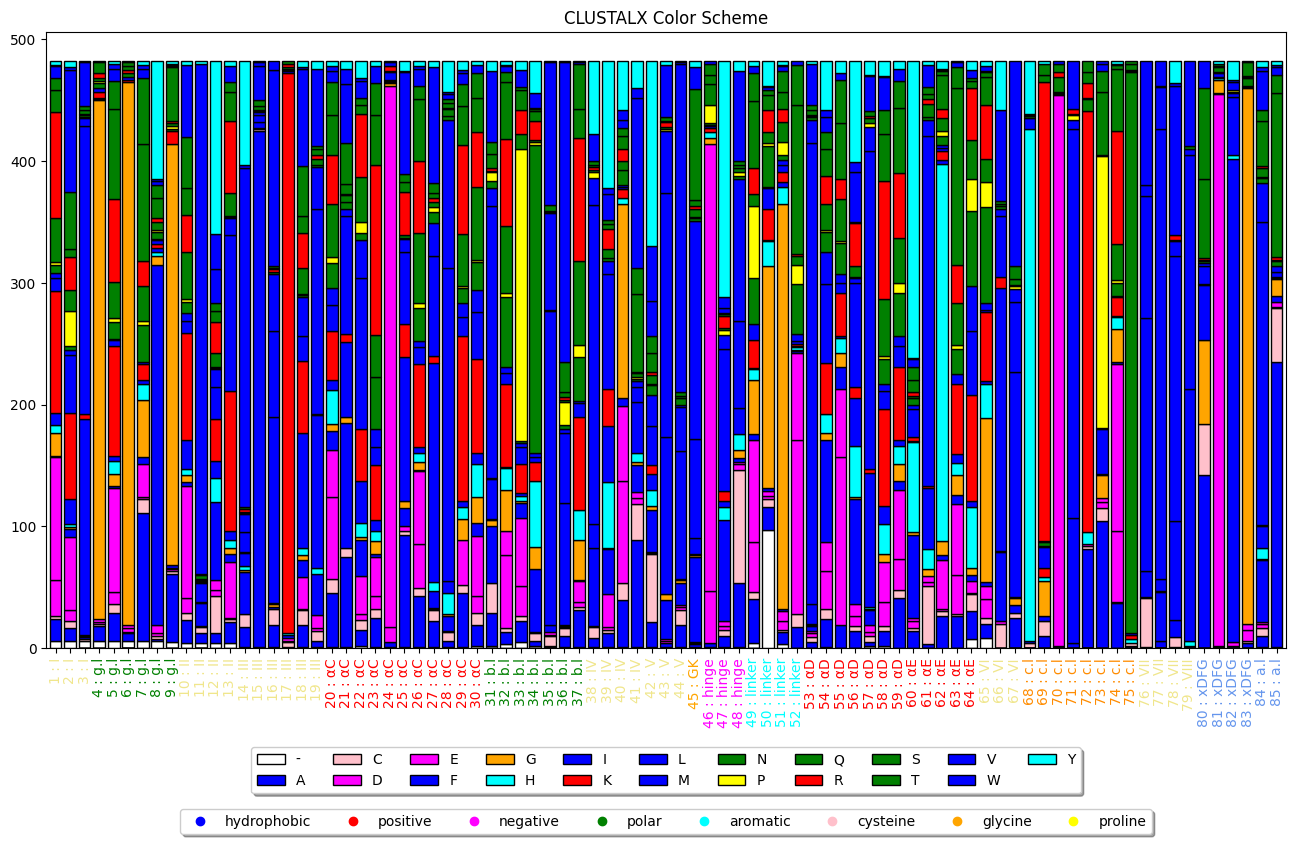

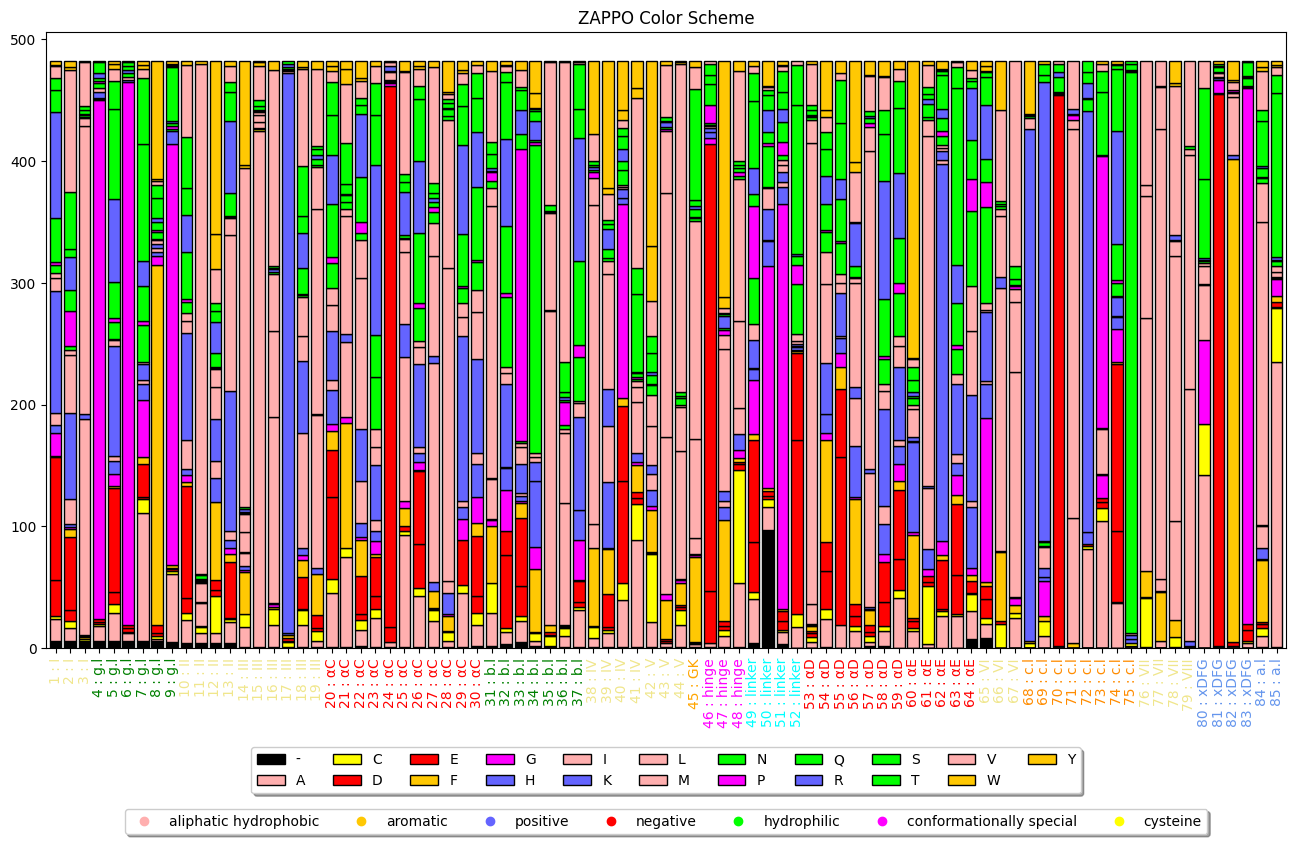

In [8]:
# change x-axis lablel to include KLIFS pocket region
df_pocket_pivot.columns = [f"{entry[0]} : {entry[1]}" for entry in klifs.LIST_POCKET_KLIFS_REGIONS]

list_cols = list(colors.DICT_COLORS.keys())
for cols in list_cols:
    print(cols)
    str_col = cols
    dict_col = colors.DICT_COLORS[str_col]["DICT_COLORS"]
    list_fill_col = [colors.map_single_letter_aa_to_color(i, dict_col) \
                     for i in df_pocket_pivot.index.tolist()]
    list_axis_col = [klifs.POCKET_KLIFS_REGION_COLORS[i[1]] for i in klifs.LIST_POCKET_KLIFS_REGIONS]
    
    if len(set(list_fill_col)) > 9:
        edgecol = "white"
        colwidth = 0.9
    else:
        edgecol = "black"
        colwidth = 0.8
    
    ax = df_pocket_pivot.T.plot(kind='bar', 
                                stacked=True, 
                                figsize=(16, 8),
                                color=list_fill_col,
                                edgecolor = edgecol, 
                                width = colwidth);
    
    for xtick, color in zip(ax.get_xticklabels(), list_axis_col):
        xtick.set_color(color)
    
    dict_annot = colors.DICT_COLORS[str_col]["DICT_ANNOTATION"]
    if dict_annot is None:
        ax.legend(loc="upper center", 
              bbox_to_anchor=(0.5, -0.15),
              fancybox=True, 
              shadow=True, 
              ncol=11)
    else:
        l1 = ax.legend(loc="upper center", 
                       bbox_to_anchor=(0.5, -0.15),
                       fancybox=True, 
                       shadow=True, 
                       ncol=11)
        handlelist = [plt.plot([], marker="o", ls="", color=color)[0] for _, color in dict_annot.items()]
        l2 = ax.legend(handlelist,
                       list(dict_annot.keys()),
                       loc="upper center", 
                       bbox_to_anchor=(0.5, -0.25),
                       fancybox=True, 
                       shadow=True, 
                       ncol=len(dict_annot))
        ax.add_artist(l1)
    plt.title(f"{cols} Color Scheme")
    plt.savefig(f"KLIFS_pocket_{cols}.pdf", bbox_inches="tight");

# Align KLIFS pocket residues to canonial sequence

In [3]:
df_klifs_narm = df_klifs.loc[~df_klifs["pocket"].isna(), ].reset_index(drop=True)
df_klifs_uniprot_narm = df_klifs_narm.merge(df_uniprot, left_on="uniprot", right_on="uniprot_id", how="left")

In [4]:
# df_klifs.loc[df_klifs["pocket"].isna(), ]
# df_klifs_narm.loc[df_klifs_narm["pocket"].apply(lambda x: "-" in x), ]
# df_klifs_uniprot_narm.iloc[1]

In [5]:
list_KLIFSPocket = []
for _, row in df_klifs_uniprot_narm.iterrows():
    uniprot_id = row["uniprot"]
    hgnc = row["name"]
    str_uniprot = row["canonical_sequence"]
    str_klifs_pocket = row["pocket"]

    dict_temp2 = klifs.iterate_klifs_alignment(str_uniprot, str_klifs_pocket)

    dict_temp1 = {"uniprotID": uniprot_id,
                  "hgncName": hgnc,
                  "uniprotSeq": str_uniprot,
                  "klifsSeq": str_klifs_pocket}

    dict_out = dict(dict_temp1, **dict_temp2)

    list_KLIFSPocket.append(KLIFSPocket(**dict_out))

In [10]:
# from dataclasses import asdict
# import json
# print(json.dumps(asdict(list_KLIFSPocket[0]), indent=4, sort_keys=False, ensure_ascii=False))

In [ ]:
list_err_narm = [] # regions that are technically missing (all "-")
list_err_concat = [] # regions that cannot be found after concatenation
list_err_match = [] # regions where no exact match is found for sequence

In [26]:
for klifspocket in list_KLIFSPocket:
    list_temp = [idx for idx, i in enumerate(klifspocket.list_substring_idxs) if i is None]
    if len(list_temp) > 0:
        print(f"{klifspocket.hgncName}")
        for idx in list_temp:
            print(f"{klifspocket.list_klifs_region[idx]}: {klifspocket.list_klifs_substr_actual[idx]}")
        print("")

SCYL1
I:I: ---

SCYL3
I:I: ---
g.l:g.l: ------

SgK495
I:I: ---
g.l:g.l: ------
II:II: ----
III:III: ------
αC:αC: -----------
b.l:b.l: -------
IV:IV: ----
V:V: ---
GK:GK: -
hinge:hinge: ---

RSKL1
I:I: ---
g.l:g.l: ------
II:II: ----

Slob
a.l:a.l: --

TBCK
I:I: ---
g.l:g.l: ------
II:II: ----

SgK307
I:I: ---
g.l:g.l: ------
II:II: ----



In [22]:
list_temp

[]

In [21]:
for klifspocket in list_KLIFSPocket:
    if sum([i is None for i in klifspocket.list_substring_idxs]) > 0:
        print(klifspocket.hgncName)

SCYL1
SCYL3
SgK495
RSKL1
Slob
TBCK
SgK307


In [18]:
list_KLIFSPocket[0]

KLIFSPocket(uniprotID='P00519', hgncName='ABL1', uniprotSeq='MLEICLKLVGCKSKKGLSSSSSCYLEEALQRPVASDFEPQGLSEAARWNSKENLLAGPSENDPNLFVALYDFVASGDNTLSITKGEKLRVLGYNHNGEWCEAQTKNGQGWVPSNYITPVNSLEKHSWYHGPVSRNAAEYLLSSGINGSFLVRESESSPGQRSISLRYEGRVYHYRINTASDGKLYVSSESRFNTLAELVHHHSTVADGLITTLHYPAPKRNKPTVYGVSPNYDKWEMERTDITMKHKLGGGQYGEVYEGVWKKYSLTVAVKTLKEDTMEVEEFLKEAAVMKEIKHPNLVQLLGVCTREPPFYIITEFMTYGNLLDYLRECNRQEVNAVVLLYMATQISSAMEYLEKKNFIHRDLAARNCLVGENHLVKVADFGLSRLMTGDTYTAHAGAKFPIKWTAPESLAYNKFSIKSDVWAFGVLLWEIATYGMSPYPGIDLSQVYELLEKDYRMERPEGCPEKVYELMRACWQWNPSDRPSFAEIHQAFETMFQESSISDEVEKELGKQGVRGAVSTLLQAPELPTKTRTSRRAAEHRDTTDVPEMPHSKGQGESDPLDHEPAVSPLLPRKERGPPEGGLNEDERLLPKDKKTNLFSALIKKKKKTAPTPPKRSSSFREMDGQPERRGAGEEEGRDISNGALAFTPLDTADPAKSPKPSNGAGVPNGALRESGGSGFRSPHLWKKSSTLTSSRLATGEEEGGGSSSKRFLRSCSASCVPHGAKDTEWRSVTLPRDLQSTGRQFDSSTFGGHKSEKPALPRKRAGENRSDQVTRGTVTPPPRLVKKNEEAADEVFKDIMESSPGSSPPNLTPKPLRRQVTVAPASGLPHKEEAGKGSALGTPAAAEPVTPTSKAGSGAPGGTSKGPAEESRVRRHKHSSESPGRDKGKLSRLKPAPPPPPAASAGKAGGKPSQSPSQEAAGEAVLGAKTKATSLVD

In [ ]:
list_KLIFSPocket[0].list_

In [16]:
sum([i is None for i in asdict(list_KLIFSPocket[0])["list_substring_idxs"]])

0

In [ ]:
list_KLIFSPocket[0].list_

In [16]:
sum([i is None for i in asdict(list_KLIFSPocket[0])["list_substring_idxs"]])

0

In [ ]:
list_keys = list(klifs.DICT_POCKET_KLIFS_REGIONS.keys())
dict_klifs_idx = {i:dict(zip(list_keys, [None for i in range(len(list_keys))])) for i in df_klifs_uniprot_narm["uniprot"]}
dict_klifs_len = copy.deepcopy(dict_klifs_idx)

list_err_narm = [] # regions that are technically missing (all "-")
list_err_concat = [] # regions that cannot be found after concatenation
list_err_match = [] # regions where no exact match is found for sequence

for idx, klifs_region in enumerate(list_keys):
    for _, row in df_klifs_uniprot_narm.iterrows():
        uniprot_id = row["uniprot"]
        hgnc = row["name"]
        str_uniprot = row["canonical_sequence"]
        str_klifs_pocket = row["pocket"]

        #TODO - add comment
        str_klifs, str_klifs_narm, list_klifs_idx = klifs.align_klifs_pocket_to_uniprot_seq(
            klifs_region_start=klifs_region,
            klifs_region_end=klifs_region,
            string_uniprot=str_uniprot,
            string_klifs=str_klifs_pocket)
        if list_klifs_idx is None:
            dict_klifs_len[uniprot_id][klifs_region], dict_klifs_idx[uniprot_id][klifs_region] = None, None
            list_err_narm.append(f"{hgnc} {klifs_region} ({str_klifs})")
        # if more than one location matches, concatenate regions
        if len(list_klifs_idx) > 1:
            # concatenate with subsequent region
            if idx + 1 < len(list_keys):
                end = dict_klifs_regions[list_keys[idx + 1]]["end"]
                str_keys = f"{key}:{list_keys[idx + 1]}"
            # concatenate with preceding region
            else:
                start = dict_klifs_regions[list_keys[idx - 1]]["start"]
                str_keys = f"{list_keys[idx - 1]}:{key}"
            test_sub = row["pocket"][start:end]
            test_sub_narm = "".join([i for i in test_sub if i != "-"])
            list_start = [i for i in range(len(test_str)) if test_str.startswith(test_sub_narm, i)]
            if len(list_start) != 1:
                list_err_concat.append(f"{row['name']} {str_keys} {len(list_start)} ({test_sub})")
                dict_klifs_idx[row["uniprot"]][key] = np.nan
            else:
                dict_klifs_idx[row["uniprot"]][key] = list_start[0]
        else:
            try:
                dict_klifs_idx[row["uniprot"]][key] = list_start[0]
            except:
                dict_klifs_idx[row["uniprot"]][key] = np.nan
                # b.l is not contiguous - need to do an alternative process
                if key != "b.l":
                    list_err_match.append(f"{row['name']} {key} {len(list_start)} ({test_sub})")

In [211]:
list_err_concat

['SCYL1 I:g.l 20 (--------W)',
 'SCYL3 I:g.l 742 (---------)',
 'SgK495 I:g.l 435 (---------)',
 'RSKL1 I:g.l 1066 (---------)',
 'TBCK I:g.l 893 (---------)',
 'SgK307 I:g.l 1497 (---------)',
 'SgK495 g.l:II 435 (----------)',
 'RSKL1 g.l:II 1066 (----------)',
 'TBCK g.l:II 893 (----------)',
 'SgK307 g.l:II 1497 (----------)',
 'DMPK1 II:III 0 (EVAVYAMKIM)',
 'KIT II:III 0 (KVVEVAVKML)',
 'CaMKK2 II:III 0 (VVKLYAMKVL)',
 'SgK495 II:III 435 (----------)',
 'SMG1 II:III 0 (LLFLYLFKGL)',
 'SgK495 III:αC 435 (-----------------)',
 'SgK495 αC:b.l 435 (------------------)',
 'SgK495 b.l:IV 435 (-----------)',
 'AMPKa1 IV:V 0 (LYQVFMV)',
 'FGFR4 IV:V 0 (LLGVYVI)',
 'MSK1 IV:V 0 (LHYAHLI)',
 'PDGFRa IV:V 0 (LLGAYII)',
 'TTN IV:V 0 (LHESVMI)',
 'CaMKK2 IV:V 0 (LVEVYMV)',
 'SgK495 IV:V 435 (-------)',
 'TBK1 IV:V 0 (LFAIVLI)',
 'IGF1R V:GK 2 (LVIM)',
 'SgK495 V:GK 435 (----)',
 'HH498 V:GK 2 (AIVT)',
 'MPSK1 V:GK 2 (WLLL)',
 'CaMKK1 V:GK 0 (LYLF)',
 'SgK307 V:GK 2 (RLVY)',
 'JAK2 GK:hinge 2 

In [204]:
list_err_narm

['SCYL1 I 1 (---)',
 'SCYL3 I 1 (---)',
 'SgK495 I 1 (---)',
 'RSKL1 I 1 (---)',
 'TBCK I 1 (---)',
 'SgK307 I 1 (---)',
 'SCYL3 g.l 1 (------)',
 'SgK495 g.l 1 (------)',
 'RSKL1 g.l 1 (------)',
 'TBCK g.l 1 (------)',
 'SgK307 g.l 1 (------)',
 'SgK495 II 1 (----)',
 'RSKL1 II 1 (----)',
 'TBCK II 1 (----)',
 'SgK307 II 1 (----)',
 'SgK495 III 1 (------)',
 'SgK495 αC 1 (-----------)',
 'SgK495 b.l 0 (-------)',
 'SgK495 IV 1 (----)',
 'SgK495 V 1 (---)',
 'SgK495 GK 1 (-)',
 'SgK495 hinge 1 (---)',
 'Slob a.l 4 (--)']

In [205]:
list_err_match

['LRRK2 I 0 (ADH)',
 'CaMKK1 I 0 (DAY)',
 'CaMKK1 g.l 0 (LQGAYG)',
 'ADCK4 linker 0 (LGVP)',
 'ATM linker 0 (TTVP)',
 'FRAP linker 0 (PCDT)',
 'PIM3 linker 0 (EAQD)',
 'PIM1 linker 0 (EVQD)',
 'PIM2 linker 0 (LAQD)',
 'TRRAP linker 0 (PVEI)',
 'ADCK1 linker 0 (FGQV)',
 'RIOK3 linker 0 (GAPK)',
 'RIOK1 linker 0 (GAPL)',
 'SMG1 linker 0 (DATP)',
 'ADCK2 linker 0 (YVSS)',
 'ADCK5 linker 0 (FCKV)',
 'ADCK3 VI 0 (NFM)']

In [213]:
pd.DataFrame(dict_klifs_idx)

,P00519,Q07912,P27037,Q13705,Q96D53,Q96RU8,Q8IWQ3,Q9Y3S1,P31749,P31751,...,Q9NSY1,Q9BXA7,Q86YV6,Q7Z695,O43293,P0C1S8,Q05823,Q9BVS4,Q3MIX3,Q58A45
I,245.0,129.0,195.0,193.0,212.0,94.0,22.0,198.0,153.0,155.0,...,54.0,15.0,109.0,284.0,16.0,215.0,368.0,98.0,203.0,492.0
g.l,248.0,132.0,198.0,196.0,215.0,97.0,25.0,201.0,156.0,158.0,...,57.0,18.0,112.0,287.0,19.0,218.0,371.0,101.0,206.0,495.0
II,254.0,138.0,204.0,202.0,221.0,103.0,31.0,207.0,162.0,164.0,...,63.0,24.0,118.0,293.0,25.0,224.0,377.0,107.0,212.0,501.0
III,267.0,154.0,215.0,213.0,233.0,116.0,44.0,220.0,175.0,177.0,...,75.0,37.0,131.0,307.0,38.0,237.0,388.0,119.0,224.0,516.0
αC,281.0,172.0,227.0,225.0,285.0,126.0,61.0,237.0,193.0,195.0,...,90.0,55.0,146.0,361.0,59.0,254.0,399.0,156.0,276.0,532.0
b.l,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IV,300.0,191.0,248.0,246.0,311.0,145.0,80.0,256.0,212.0,214.0,...,110.0,74.0,165.0,387.0,78.0,274.0,419.0,177.0,302.0,550.0
V,311.0,201.0,263.0,261.0,318.0,156.0,91.0,271.0,223.0,225.0,...,126.0,86.0,176.0,394.0,89.0,285.0,430.0,184.0,309.0,567.0
GK,314.0,204.0,266.0,264.0,321.0,159.0,94.0,274.0,226.0,228.0,...,129.0,89.0,179.0,397.0,92.0,288.0,433.0,NaN,312.0,570.0
hinge,315.0,205.0,267.0,265.0,322.0,160.0,95.0,275.0,227.0,229.0,...,130.0,90.0,180.0,398.0,93.0,289.0,434.0,188.0,313.0,571.0


In [155]:
len(list_err)

114

In [147]:
test_sub

'VF'

In [146]:
"".join([i for i in test_sub])

'VF'

In [28]:
df_klifs_uniprot_narm.iloc[0]

family                                                              Abl
full_name             ABL proto-oncogene 1, non-receptor tyrosine ki...
gene_name                                                          ABL1
group                                                                TK
iuphar                                                           1923.0
kinase_ID                                                         392.0
name                                                               ABL1
pocket                HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...
species                                                           Human
subfamily                                                           NaN
uniprot                                                          P00519
uniprot_id                                                       P00519
hgnc_name                                                          ABL1
canonical_sequence    MLEICLKLVGCKSKKGLSSSSSCYLEEALQRPVASDFEPQGL

In [ ]:
list_klifs_region = list(set([i[1] for i in klifs.POCKET_KLIFS_REGIONS]))

list_klifs_start = []
list_klifs_end = []

for region in list_klifs_region:
    list_region = [i[0] for i in klifs.POCKET_KLIFS_REGIONS if i[1] == region]
    start, end = min(list_region), max(list_region)
    list_klifs_start.append(start), list_klifs_end.append(end)

idx_sort = np.argsort(np.array(list_klifs_start))
list_klifs_region = list(np.array(list_klifs_region)[idx_sort])
list_klifs_start = list(np.array(list_klifs_start)[idx_sort])
list_klifs_end = list(np.array(list_klifs_end)[idx_sort])

dict_klifs_regions = {region : {"start" : list_klifs_start[idx], 
                                "end" : list_klifs_end[idx]} for idx, region in enumerate(list_klifs_region)}

In [54]:
for key, val in dict_klifs_regions.items():
    val["start"]

{'I': {'start': 1, 'end': 3},
 'g.l': {'start': 4, 'end': 9},
 'II': {'start': 10, 'end': 13},
 'III': {'start': 14, 'end': 19},
 'αC': {'start': 20, 'end': 30},
 'b.l': {'start': 31, 'end': 37},
 'IV': {'start': 38, 'end': 41},
 'V': {'start': 42, 'end': 44},
 'GK': {'start': 45, 'end': 45},
 'hinge': {'start': 46, 'end': 48},
 'linker': {'start': 49, 'end': 52},
 'αD': {'start': 53, 'end': 59},
 'αE': {'start': 60, 'end': 64},
 'VI': {'start': 65, 'end': 67},
 'c.l': {'start': 68, 'end': 75},
 'VII': {'start': 76, 'end': 78},
 'VIII': {'start': 79, 'end': 79},
 'xDFG': {'start': 80, 'end': 83},
 'a.l': {'start': 84, 'end': 85}}

In [55]:
dict_klifs_regions["I"]["start"]-1:dict_klifs_regions["I"]["end"]-1

{'start': 1, 'end': 3}